# Possession Predictor
By: Pranay Singla

## Import libraries

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [2]:
import os
import csv
import random
import time

In [3]:
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential

## Exploratory Data Analysis


In [7]:
labels_df = pd.read_csv('../labels.csv')
labels_df

,frame,label
0,0,1
1,10,1
2,20,1
3,30,1
4,40,1
...,...,...
9319,93190,1
9320,93200,1
9321,93210,1
9322,93220,1


In [8]:
FRAMES_PER_SECOND = 3

In [9]:
# Possible labels
# - 0: Ball not in play 
# - 1: Chelsea has the ball
# - 2: Manchester United has the ball
# - 3: Replay

def get_human_label(label):
    if label == 0:
        return('dead ball')
    elif label == 1:
        return('chelsea')
    elif label == 2:
        return('man utd')
    elif label == 3:
        return('replay')

In [10]:
labels_ = labels_df.copy()
labels_['human_label'] = list(map(get_human_label, labels_['label']))
labels_['minutes'] = 1 / (60 * FRAMES_PER_SECOND)
labels_

,frame,label,human_label,minutes
0,0,1,chelsea,0.005556
1,10,1,chelsea,0.005556
2,20,1,chelsea,0.005556
3,30,1,chelsea,0.005556
4,40,1,chelsea,0.005556
...,...,...,...,...
9319,93190,1,chelsea,0.005556
9320,93200,1,chelsea,0.005556
9321,93210,1,chelsea,0.005556
9322,93220,1,chelsea,0.005556


### Frequency of each label

In [11]:
minutes_per_label = labels_.groupby('human_label')['minutes']\
                           .sum()\
                           .reset_index()\
                           .sort_values('minutes', ascending = False)

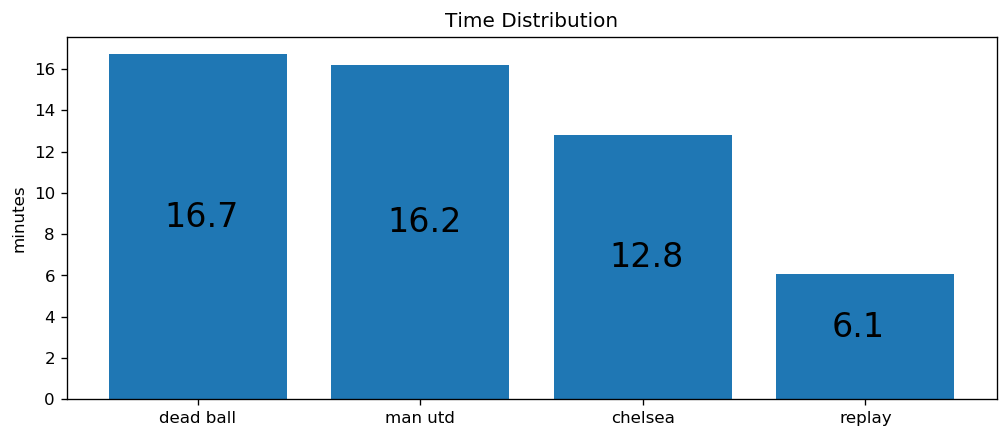

In [12]:
fig, axes = plt.subplots(figsize=(10,4), dpi=120)
plt.bar(minutes_per_label['human_label'], minutes_per_label['minutes'])

for i, v in enumerate(minutes_per_label['minutes']):
    plt.text(i - 0.15, v / 2, str(round(v, 1)), size = 20)

plt.ylabel('minutes')    
plt.title('Time Distribution')
plt.show()

### Possession Distribution over time

In [13]:
pivot_labels = pd.pivot_table(labels_, values='minutes', index=['frame'],
                              columns=['human_label'], aggfunc=np.sum, fill_value=0)

pivot_labels['frame'] = pivot_labels.index
pivot_labels = pivot_labels.reset_index(drop=True).rename_axis(None, axis=1)

cum_pivot_labels = pivot_labels.copy()
cum_pivot_labels['chelsea'] = np.cumsum(pivot_labels['chelsea'])
cum_pivot_labels['man utd'] = np.cumsum(pivot_labels['man utd'])
cum_pivot_labels['dead ball'] = np.cumsum(pivot_labels['dead ball'])
cum_pivot_labels['replay'] = np.cumsum(pivot_labels['replay'])

cum_pivot_labels = cum_pivot_labels[['frame', 'chelsea', 'man utd', 'dead ball', 'replay']]

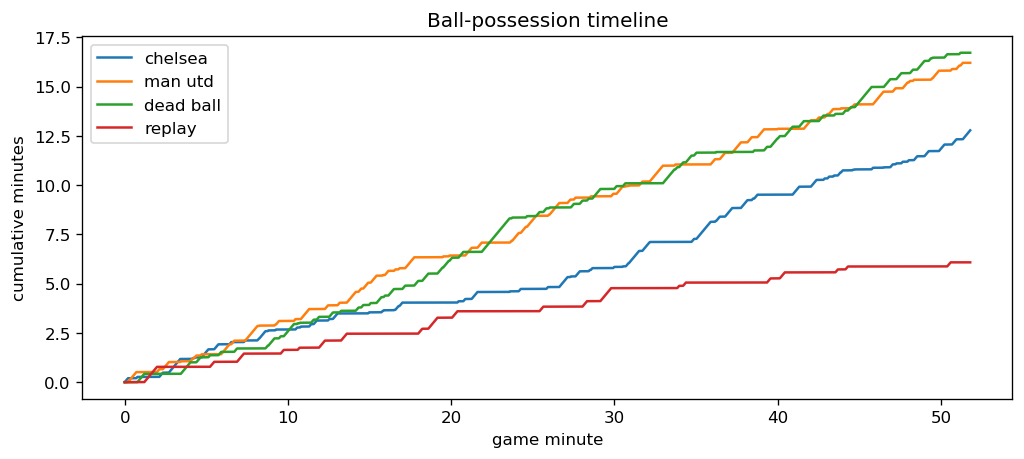

In [14]:
fig, axes = plt.subplots(figsize=(10,4), dpi=120)
minutes = cum_pivot_labels['frame'] / (10 * 3 * 60)
df_minutes_labels = cum_pivot_labels.drop('frame', axis = 1)
for label in list(df_minutes_labels):
    plt.plot(minutes, df_minutes_labels[label], label = label)

plt.xlabel('game minute')
plt.ylabel('cumulative minutes')
plt.legend()
plt.title('Ball-possession timeline')
plt.show()

### Why there are several jumps in the series? 

In [15]:
time_unit = 1 / FRAMES_PER_SECOND
current_label = labels_['human_label'][0]
length = 0
sequences = []

for label in labels_['human_label'][:-1]:
    if label == current_label:
        length += time_unit
    else:
        sequences.append((current_label, length))
        current_label = label
        length = time_unit
sequences.append((current_label, length+time_unit)) 
sequences = pd.DataFrame(sequences)
sequences.columns = ['label', 'seconds']

top_sequences = sequences.sort_values('seconds', ascending=False).head(20)

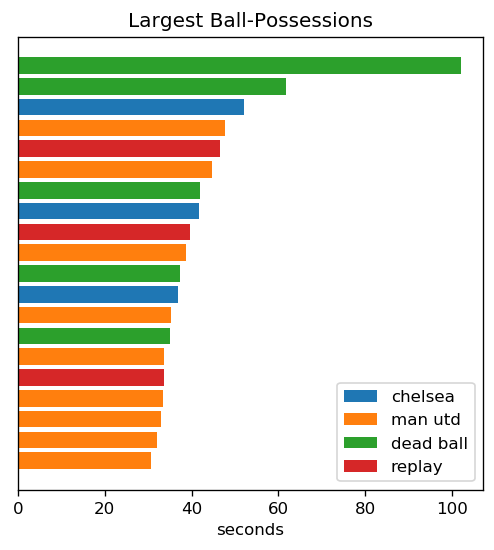

In [16]:
fig, axes = plt.subplots(figsize=(5,5), dpi=120)

y_values = np.arange(top_sequences.shape[0],0,-1)
labels_ = ['chelsea', 'man utd', 'dead ball', 'replay']

for label in labels_:
    mask = top_sequences['label'] == label
    plt.barh(y_values[mask], top_sequences['seconds'][mask], label = label)

plt.legend()
plt.yticks([])
plt.xlabel('seconds')
plt.title('Largest Ball-Possessions')
plt.show()

## Data Wrangling

In [17]:
def frame_num_to_image_path(frame):
    return("ExtractFrames/match_frames/frame%s.jpg" % frame)

labels_df['img_path'] = list(map(frame_num_to_image_path, labels_df['frame']))
labels_df

,frame,label,img_path
0,0,1,ExtractFrames/match_frames/frame0.jpg
1,10,1,ExtractFrames/match_frames/frame10.jpg
2,20,1,ExtractFrames/match_frames/frame20.jpg
3,30,1,ExtractFrames/match_frames/frame30.jpg
4,40,1,ExtractFrames/match_frames/frame40.jpg
...,...,...,...
9319,93190,1,ExtractFrames/match_frames/frame93190.jpg
9320,93200,1,ExtractFrames/match_frames/frame93200.jpg
9321,93210,1,ExtractFrames/match_frames/frame93210.jpg
9322,93220,1,ExtractFrames/match_frames/frame93220.jpg


Tag: man utd


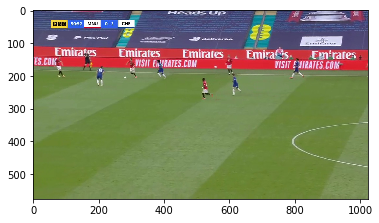

Tag: man utd


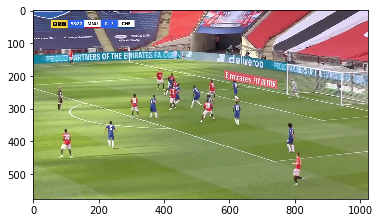

Tag: replay


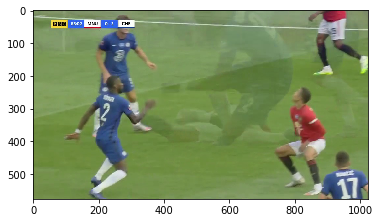

Tag: chelsea


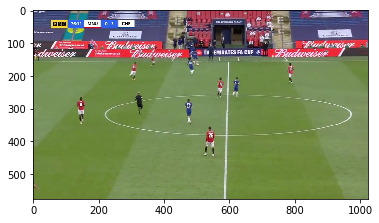

Tag: man utd


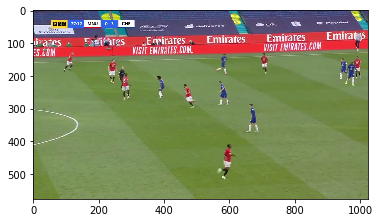

Tag: dead ball


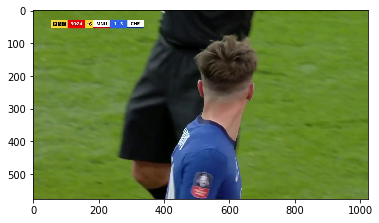

In [20]:
random.seed(220)
for index, row in labels_df.iterrows():
    frame = row['frame']
    label = row['label']
    img_path = row['img_path']

    # Verify the image is in the folder
    assert os.path.exists(img_path)   

  # Shows some images
    if random.random() < 0.001:
        image_ = mpimg.imread(img_path)
        print('Tag: %s' % get_human_label(label))
        plt.gca().clear()
        plt.imshow(image_)
        plt.show()      

## Split train, validation and test 

training using only the first 20 minutes, predicting the next 25.

In [19]:
FRAME_THRESHOLD = 3616 #First 20 minutes
train_val = labels_df[:FRAME_THRESHOLD]
test = labels_df[FRAME_THRESHOLD:-12] #ensuring batch size of 32
train, val = train_test_split(train_val, test_size=0.2, random_state=2020)

## Save activations from Inception V3 for all the images

In [21]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 8s 0us/step


In [22]:
# extract activations using the model above. 
def image_to_activations(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    activations = tf.keras.applications.inception_v3.preprocess_input(img)
    return activations, image_path

In [24]:
image_path_set = set(labels_df['img_path'])

print("Images to preprocess", len(image_path_set))

Images to preprocess 9324


In [25]:
# extracting activations for each image

# Create a dataset to load each image off disk, and extract activations
activation_dataset = tf.data.Dataset.from_tensor_slices(list(image_path_set))
activation_dataset = activation_dataset.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# Saving all activations in NumPy format
for img_batch, path_batch in activation_dataset:
  batch_features = image_features_extract_model(img_batch)
  for bf, p in zip(batch_features, path_batch):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())  

## Convert data to an appropiate batch format to train the model

In [ ]:
labels_train = list([1.0 * label for label in train['label']]) 
images_train = list(train['img_path']) 

labels_val = list([1.0 * label for label in val['label']]) 
images_val = list(val['img_path']) 

labels_test = list([1.0 * label for label in test['label']]) 
images_test = list(test['img_path']) 

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [ ]:
def load_np(img_path, label):
    activations = np.load(img_path.decode('utf-8')+'.npy')
    return activations, label, img_path

def create_dataset(images, labels, shuff = True):
    dataset = tf.data.Dataset.from_tensor_slices((images, 
                                                  labels))
    # Load the cached activations off disk
    dataset = dataset.map(lambda x, y: tf.numpy_function(
        load_np, [x, y], [tf.float32, tf.float32, tf.string]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # Shuffle and batch
    if shuff:
        dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    else:
        dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
train_ds = create_dataset(images_train, labels_train, shuff = False)
val_ds = create_dataset(images_val, labels_val, shuff = False)
test_ds = create_dataset(images_test, labels_test, shuff = False)

In [ ]:
my_iterator = iter(train_ds)
activations_batch, labels_batch, paths_batch = next(my_iterator)

print(activations_batch.shape, 
      labels_batch.shape, 
      paths_batch.shape)

print(activations_batch, 
      labels_batch, 
      paths_batch)

## CNN Approach

### Design the CNN

In [ ]:
image_input = Input(shape=(8, 8, 2048)) 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image = vision_model(image_input) 

# Add dense layers between the activations and the output
dense = Dense(64, activation='relu')(encoded_image)
dense = Dense(64, activation='relu')(dense)

# Next, add a binary classifier on top
output = Dense(4, activation='softmax')(dense)

# Your final model
model = Model(inputs=image_input, outputs=output)

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### Train on a single batch to verify everything is working

In [ ]:
# Retrieve a batch of data from your train dataset
activations_batch, labels_batch, paths_batch = next(iter(train_ds))

In [ ]:
for i in range(100):
  metrics = model.train_on_batch(activations_batch, labels_batch)

In [ ]:
print('Loss: %f' % metrics[0])
print('Accuracy: %f' % metrics[1])

In [ ]:
for prediction, label in zip(model.predict(x=activations_batch), labels_batch):
  print(prediction, label.numpy())

### Manage checkpoints in case we want to fit the model for a long time

In [ ]:
checkpoint_dir = os.path.join(drive_root, "soccer_checkpoints/CNN_")
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
    print("Checkpoints folder already exists")
else:
    print("Creating a checkpoints directory")
    os.makedirs(checkpoint_dir)

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

### Fit the model

In [ ]:
# Utilities to help us record metrics.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [ ]:
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, label_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=activation_batch)
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions)

In [ ]:
# Used to track loss and accuracy as we go
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 50 

# Training loop
for epoch in range(epochs):

    start = time.time()

    # Train for one epoch
    for activation_batch, label_batch, path_batch in train_ds:
        result = model.train_on_batch(x=activation_batch, y=label_batch)

        # Record metrics after each batch
        train_loss(result[0])
        train_accuracy(result[1])

    # Evaluate for a few steps
    evaluate(max_steps=100)

    # Print progress
    template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
    print(template.format(epoch,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          val_loss.result(),
                          val_accuracy.result() * 100,
                          time.time() - start))
    
    # Record history
    train_loss_history.append(train_loss.result())
    train_acc_history.append(train_accuracy.result() * 100)
    val_loss_history.append(val_loss.result())
    val_acc_history.append(val_accuracy.result() * 100)

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Save a checkpoint after each epoch
    print("Saving weights")
    model.save_weights(checkpoint_path.format(epoch=epoch))

In [ ]:
def plot(loss, acc, val_loss, val_acc):
  
  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

#### Predict on the test dataset and save results

In [ ]:
# Restore the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_dir)
assert latest != None
model.load_weights(latest)
print("loaded weights from", latest)

In [ ]:
random.seed(2021)
acc_list = list()
predictions_list = list()
confidences_list = list()
paths_list = list()

for activation_batch, label_batch, path_batch in test_ds:
    score, acc = model.evaluate(activation_batch, label_batch, verbose=0)
    acc_list.append(acc)
    
    preds = model.predict(activation_batch)
    predictions_batch = list(np.argmax(preds, axis = 1))
    confidences_batch = list(np.max(preds, axis = 1))
    paths_batch = list(path_batch.numpy())
    paths_batch = [path.decode('utf-8') for path in paths_batch]
    labels_batch = list(label_batch.numpy())

    predictions_list = predictions_list + predictions_batch
    confidences_list = confidences_list + confidences_batch
    paths_list = paths_list + paths_batch

    for i in range(len(labels_batch)):
        if random.random() < 0.002:
            print('True label: %s' % get_human_label(labels_batch[i]))
            print('Predicted label: %s' % get_human_label(predictions_batch[i]))
            print('Confidence of the prediction: %s' % confidences_batch[i])
            image_ = mpimg.imread(paths_batch[i])
            plt.gca().clear()
            plt.imshow(image_)
            plt.show()     

In [ ]:
print('The test accuracy is: %f' % np.mean(acc_list))

In [ ]:
preds_df = pd.DataFrame({'img_path': paths_list,
                         'pred_label': predictions_list,
                         'confidence': confidences_list      
})

In [ ]:
predictions_cnn = test.set_index('img_path').join(preds_df.set_index('img_path')).reset_index()
predictions_cnn

In [ ]:
pred_labels = pd.Series(map(get_human_label, predictions_cnn['pred_label']))
labels = pd.Series(map(get_human_label, predictions_cnn['label']))

In [ ]:
pd.crosstab(labels, pred_labels,
            rownames = ['label'], colnames = ['pred'],
            normalize = 'all', margins = True)

#### Recall

In [ ]:
recall = pd.crosstab(labels, pred_labels,
                     rownames = ['label'], colnames = ['pred'],
                     normalize = 'index')
recall

#### Precision

In [ ]:
precision = pd.crosstab(labels, pred_labels,
                        rownames = ['label'], colnames = ['pred'],
                        normalize = 'columns')
precision

## CNN + RNN Approach

### Design the CNN + RNN

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, LSTM, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, GRU, Concatenate
from tensorflow.keras.models import Model, Sequential

image_input = Input(shape=(8, 8, 2048), batch_size=32) 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(GlobalAveragePooling2D())
encoded_image = vision_model(image_input)
encoded_image_drop = Dropout(0.5)(encoded_image)

# Adding Gated Recurred Units
encoded_image_reshape = Reshape((1, 2048))(encoded_image_drop)
gru_1 = GRU(32, stateful=True, dropout=0.3, recurrent_dropout=0.3)(encoded_image_reshape)
#gru_2 = GRU(64, stateful=True, dropout=0.3, recurrent_dropout=0.3)(gru_1)

# Combining both CNN and RNN outputs
x = Concatenate()([gru_1, encoded_image_drop])

# Add dense layers between the activations and the output
dense = Dense(64, activation='relu')(x)
dense = Dense(64, activation='relu')(dense)

# Next, add a binary classifier on top
output = Dense(4, activation='softmax')(dense)

model = Model(inputs=image_input, outputs=output)

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### Train on a single batch to verify everything is working

In [ ]:
# Retrieve a batch of data from your train dataset
activations_batch, labels_batch, paths_batch = next(iter(train_ds))

In [ ]:
for i in range(100):
  metrics = model.train_on_batch(activations_batch, labels_batch)

In [ ]:
print('Loss: %f' % metrics[0])
print('Accuracy: %f' % metrics[1])

In [ ]:
for prediction, label in zip(model.predict(x=activations_batch), labels_batch):
  print(prediction, label.numpy())

### Manage checkpoints in case we want to fit the model for a long time

In [ ]:
checkpoint_dir = os.path.join(drive_root, "soccer_checkpoints/RNN")
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
    print("Checkpoints folder already exists")
else:
    print("Creating a checkpoints directory")
    os.makedirs(checkpoint_dir)

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

### Fit the model

In [ ]:
# Utilities to help us record metrics.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [ ]:
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, label_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=activation_batch)
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions)

In [ ]:
# Used to track loss and accuracy as we go
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 50 

# Training loop
for epoch in range(epochs):

    start = time.time()

    # Train for one epoch
    for activation_batch, label_batch, path_batch in train_ds:
        result = model.train_on_batch(x=activation_batch, y=label_batch)

        # Record metrics after each batch
        train_loss(result[0])
        train_accuracy(result[1])

    # Evaluate for a few steps
    evaluate(max_steps=100)

    # Print progress
    template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
    print(template.format(epoch,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          val_loss.result(),
                          val_accuracy.result() * 100,
                          time.time() - start))
    
    # Record history
    train_loss_history.append(train_loss.result())
    train_acc_history.append(train_accuracy.result() * 100)
    val_loss_history.append(val_loss.result())
    val_acc_history.append(val_accuracy.result() * 100)

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Save a checkpoint after each epoch
    print("Saving weights")
    model.save_weights(checkpoint_path.format(epoch=epoch))

In [ ]:
def plot(loss, acc, val_loss, val_acc):
  
  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

#### Predict on the test dataset and save results

In [ ]:
# Restore the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_dir)
assert latest != None
model.load_weights(latest)
print("loaded weights from", latest)

In [ ]:
random.seed(2021)
acc_list = list()
predictions_list = list()
confidences_list = list()
paths_list = list()

for activation_batch, label_batch, path_batch in test_ds:
    score, acc = model.evaluate(activation_batch, label_batch, verbose=0)
    acc_list.append(acc)
    
    preds = model.predict(activation_batch)
    predictions_batch = list(np.argmax(preds, axis = 1))
    confidences_batch = list(np.max(preds, axis = 1))
    paths_batch = list(path_batch.numpy())
    paths_batch = [path.decode('utf-8') for path in paths_batch]
    labels_batch = list(label_batch.numpy())

    predictions_list = predictions_list + predictions_batch
    confidences_list = confidences_list + confidences_batch
    paths_list = paths_list + paths_batch

    for i in range(len(labels_batch)):
        if random.random() < 0.002:
            print('True label: %s' % get_human_label(labels_batch[i]))
            print('Predicted label: %s' % get_human_label(predictions_batch[i]))
            print('Confidence of the prediction: %s' % confidences_batch[i])
            image_ = mpimg.imread(paths_batch[i])
            plt.gca().clear()
            plt.imshow(image_)
            plt.show()     

In [ ]:
print('The test accuracy is: %f' % np.mean(acc_list))

In [ ]:
preds_df = pd.DataFrame({'img_path': paths_list,
                         'pred_label': predictions_list,
                         'confidence': confidences_list      
})

In [ ]:
predictions_rnn = test.set_index('img_path').join(preds_df.set_index('img_path')).reset_index()
predictions_rnn

In [ ]:
pred_labels = pd.Series(map(get_human_label, predictions_rnn['pred_label']))
labels = pd.Series(map(get_human_label, predictions_rnn['label']))

In [ ]:
pd.crosstab(labels, pred_labels,
            rownames = ['label'], colnames = ['pred'],
            normalize = 'all', margins = True)

#### Recall

In [ ]:
recall = pd.crosstab(labels, pred_labels,
                     rownames = ['label'], colnames = ['pred'],
                     normalize = 'index')
recall

#### Precision

In [ ]:
precision = pd.crosstab(labels, pred_labels,
                        rownames = ['label'], colnames = ['pred'],
                        normalize = 'columns')
precision

## Scene-based Approach

Scene-based approach means that we will be utilizing "scenes" instead of singular frames. Scenes are build up over 6 sequential frames (2 seconds of real-time) where the game state is constant over all 6 frames. No two scenes can share any frames.

### Pipeline changes due to scene vs image loading

In [ ]:
labels_path = os.path.join(drive_root, "labels_scene.csv")
labels_df = pd.read_csv(labels_path)
labels_ = labels_df.copy()

labels_['human_label'] = list(map(get_human_label, labels_['label']))
labels_['minutes'] = 1 / (60 * 3)
labels_df['img_path'] = list(map(frame_num_to_image_path, labels_df['frame']))
labels_df

Train/test split on only scenes





In [ ]:
labels_df = labels_df.sample(frac=1)
FRAME_THRESHOLD = int(labels_df.shape[0]*2/3)
train_val = labels_df[:FRAME_THRESHOLD]
test = labels_df[FRAME_THRESHOLD:]
train, val = train_test_split(train_val, test_size=0.2, random_state=2019)

#### Convert data to an appropiate batch format to train the model

In [ ]:
labels_train = list([1.0 * label for label in train['label']]) 
images_train = list(train['img_path']) 

labels_val = list([1.0 * label for label in val['label']]) 
images_val = list(val['img_path']) 

labels_test = list([1.0 * label for label in test['label']]) 
images_test = list(test['img_path']) 

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

#modify to return past 2 seconds of activations instead of just 1 frame
def load_np(img_path, label):
    img_number = int(img_path.decode('utf-8').split('/')[3][5:-4])
    activation_0 = np.load(img_path.decode('utf-8')+'.npy')
    activation_1 = np.load(img_path.decode('utf-8').replace(
        str(img_number+10), str(img_number)) + '.npy')
    activation_2 = np.load(img_path.decode('utf-8').replace(
        str(img_number+20), str(img_number)) + '.npy')
    activation_3 = np.load(img_path.decode('utf-8').replace(
        str(img_number+30), str(img_number)) + '.npy')
    activation_4 = np.load(img_path.decode('utf-8').replace(
        str(img_number+40), str(img_number)) + '.npy')
    activation_5 = np.load(img_path.decode('utf-8').replace(
        str(img_number+50), str(img_number)) + '.npy')
    activations = np.dstack((activation_0, activation_1, activation_2, 
                            activation_3, activation_4, activation_5))
    return activations, label, img_path

def create_dataset(images, labels, shuff = True):
    dataset = tf.data.Dataset.from_tensor_slices((images, 
                                                  labels))
    # Load the cached activations off disk
    dataset = dataset.map(lambda x, y: tf.numpy_function(
        load_np, [x, y], [tf.float32, tf.float32, tf.string]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # Shuffle and batch
    if shuff:
        dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    else:
        dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
train_ds = create_dataset(images_train, labels_train)
val_ds = create_dataset(images_val, labels_val)
test_ds = create_dataset(images_test, labels_test, shuff = False)

In [ ]:
my_iterator = iter(train_ds)
activations_batch, labels_batch, paths_batch = next(my_iterator)

print(activations_batch.shape, 
      labels_batch.shape, 
      paths_batch.shape)

### Design the model

In [ ]:
image_input = Input(shape=(8, 8, 2048*6)) #must multiply input by 6 in scene 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image = vision_model(image_input) 

# Add dense layers between the activations and the output
dense = Dense(64, activation='relu')(encoded_image)
dense = Dense(64, activation='relu')(dense)

# Next, add a binary classifier on top
output = Dense(4, activation='softmax')(dense)

# Your final model
model = Model(inputs=image_input, outputs=output)

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### Train on a single batch to verify everything is working

In [ ]:
# Retrieve a batch of data from your train dataset
activations_batch, labels_batch, paths_batch = next(iter(train_ds))

In [ ]:
for i in range(100):
  metrics = model.train_on_batch(activations_batch, labels_batch)

In [ ]:
print('Loss: %f' % metrics[0])
print('Accuracy: %f' % metrics[1])

In [ ]:
for prediction, label in zip(model.predict(x=activations_batch), labels_batch):
  print(prediction, label.numpy())

### Manage checkpoints in case we want to fit the model for a long time

In [ ]:
checkpoint_dir = os.path.join(drive_root, "soccer_checkpoints/SCENE")
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
    print("Checkpoints folder already exists")
else:
    print("Creating a checkpoints directory")
    os.makedirs(checkpoint_dir)

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

### Fit the model

In [ ]:
# Utilities to help us record metrics.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [ ]:
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, label_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=activation_batch)
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions)

In [ ]:
# Used to track loss and accuracy as we go
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 50

# Training loop
for epoch in range(epochs):

    start = time.time()

    # Train for one epoch
    for activation_batch, label_batch, path_batch in train_ds:
        result = model.train_on_batch(x=activation_batch, y=label_batch)

        # Record metrics after each batch
        train_loss(result[0])
        train_accuracy(result[1])

    # Evaluate for a few steps
    evaluate(max_steps=100)

    # Print progress
    template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
    print(template.format(epoch,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          val_loss.result(),
                          val_accuracy.result() * 100,
                          time.time() - start))
    
    # Record history
    train_loss_history.append(train_loss.result())
    train_acc_history.append(train_accuracy.result() * 100)
    val_loss_history.append(val_loss.result())
    val_acc_history.append(val_accuracy.result() * 100)

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Save a checkpoint after each epoch
    print("Saving weights")
    model.save_weights(checkpoint_path.format(epoch=epoch))

In [ ]:
def plot(loss, acc, val_loss, val_acc):
  
  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

#### Predict on the test dataset and save results

In [ ]:
# Restore the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_dir)
assert latest != None
model.load_weights(latest)
print("loaded weights from", latest)

In [ ]:
random.seed(2021)
acc_list = list()
predictions_list = list()
confidences_list = list()
paths_list = list()

for activation_batch, label_batch, path_batch in test_ds:
    score, acc = model.evaluate(activation_batch, label_batch, verbose=0)
    acc_list.append(acc)
    
    preds = model.predict(activation_batch)
    predictions_batch = list(np.argmax(preds, axis = 1))
    confidences_batch = list(np.max(preds, axis = 1))
    paths_batch = list(path_batch.numpy())
    paths_batch = [path.decode('utf-8') for path in paths_batch]
    labels_batch = list(label_batch.numpy())

    predictions_list = predictions_list + predictions_batch
    confidences_list = confidences_list + confidences_batch
    paths_list = paths_list + paths_batch

    for i in range(len(labels_batch)):
        if random.random() < 0.002:
            print('True label: %s' % get_human_label(labels_batch[i]))
            print('Predicted label: %s' % get_human_label(predictions_batch[i]))
            print('Confidence of the prediction: %s' % confidences_batch[i])
            image_ = mpimg.imread(paths_batch[i])
            plt.gca().clear()
            plt.imshow(image_)
            plt.show()     

In [ ]:
print('The test accuracy is: %f' % np.mean(acc_list))

In [ ]:
preds_df = pd.DataFrame({'img_path': paths_list,
                         'pred_label': predictions_list,
                         'confidence': confidences_list      
})

In [ ]:
predictions_scene = test.set_index('img_path').join(preds_df.set_index('img_path')).reset_index()
predictions_scene

In [ ]:
pred_labels = pd.Series(map(get_human_label, predictions_scene['pred_label']))
labels = pd.Series(map(get_human_label, predictions_scene['label']))

In [ ]:
pd.crosstab(labels, pred_labels,
            rownames = ['label'], colnames = ['pred'],
            normalize = 'all', margins = True)

#### Recall

In [ ]:
recall = pd.crosstab(labels, pred_labels,
                     rownames = ['label'], colnames = ['pred'],
                     normalize = 'index')
recall

#### Precision

In [ ]:
precision = pd.crosstab(labels, pred_labels,
                        rownames = ['label'], colnames = ['pred'],
                        normalize = 'columns')
precision

## NOTEBOOK COMPLETE